In [ ]:
# default_exp main
from nbdev import *
from utilities.ipynb_docgen import *
import pandas as pd
import matplotlib.pyplot as plt
!date

Thu Aug 26 03:50:14 PDT 2021


# wtlike interface
> Top-level interface to the rest of the package

In [ ]:
# export
from wtlike.bayesian import get_bb_partition
from wtlike.lightcurve import fit_cells, LightCurve, flux_plot
from wtlike.cell_data import partition_cells

class WtLike(LightCurve):
    """
    Summary
    ---------
    There are three layers of initialization, implemented in superclasses,
    each with parameters. The classnames, associated parameters and data members set:

    SourceData -- load photons and exposure
        parameters:
          - source : name, a PointSource object, or a Simulation object
          - config [Config()] : basic configuration
          - week_range [None] : range of weeks to load
          - key [''] : the cache key: '' means construct one with the source name, None to disable
          - clear [False] : if using cache, clear the contents first
        sets:
          - photons
          - exposure

    CellData -- create cells
        parameters:
          - time_bins [Config().time_bins] : binning: start, stop, binsize
        sets:
          - cells

    LightCurve -- likelihood analysis of the cells
        parameters:
          - e_min [10] -- threshold for exposure (cm^2 units)
          - n_min [2]  -- likelihood has trouble with this few
          - lc_key [None] -- possible cache for light curve
        sets:
          - fits, fluxes

    WtLike (this class) -- no parameters (may add BB-specific ones)
        Implements:  bb_view, plot_BB
        sets:
          - bb_flux  (only if bb_view invoked)

    """
    def bb_view(self, p0=0.05, key=None, clear=False):
        """Return a view with the BB analysis applied

        - p0 -- false positive probability parameter

        Its `plot` function will by default show an overplot on the parent's data points.
        """
        #  a new instance
        r = self.view()

        # bb analysis on this to make new  set of cells and poisson fits
        bb_edges  = get_bb_partition(self.config, self.fits,  p0=p0, key=key, clear=clear)
        r.cells = partition_cells(self.config, self.cells, bb_edges)

        r.fits = fit_cells(self.config, r.cells, )
        r.isBB = True
        r.bayes_p0 = p0
        return r

    def plot(self, *pars, **kwargs):

        if getattr(self, 'isBB',  None) is None:
            return super().plot(*pars, **kwargs)
        else:
            return self.plot_bb(*pars, **kwargs)

    def plot_bb(self, ax=None, **kwargs):
        """Plot the light curve with BB overplot
        """
        import matplotlib.pyplot as plt
        self.check_plot_kwargs(kwargs)
        figsize = kwargs.pop('figsize', (12,4))
        fignum = kwargs.pop('fignum', 1)
        ts_min = kwargs.pop('ts_min',-1)
        source_name =kwargs.pop('source_name', self.source_name)
        fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)


        colors = kwargs.pop('colors', ('lightblue', 'wheat', 'blue') )
        flux_plot(self.parent.fits, ax=ax, colors=colors, source_name=source_name,
                  label=self.step_name+' bins', **kwargs)
        flux_plot(self.fits, ax=ax, step=True,
                  label=f'BB (p0={100*self.bayes_p0:.0f}%)', zorder=10,**kwargs)
        ax.grid(alpha=0.5)
        fig.set_facecolor('white')
        return fig

In [ ]:
show_doc(WtLike)
show_doc(WtLike.bb_view)

<h2 id="WtLike" class="doc_header"><code>class</code> <code>WtLike</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>WtLike</code>(**\*`pars`**, **\*\*`kwargs`**) :: [`LightCurve`](/wtlikelightcurve#LightCurve)

Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- possible cache for light curve
    sets:
      - fits, fluxes

WtLike (this class) -- no parameters (may add BB-specific ones)
    Implements:  bb_view, plot_BB
    sets:
      - bb_flux  (only if bb_view invoked)

<h4 id="WtLike.bb_view" class="doc_header"><code>WtLike.bb_view</code><a href="__main__.py#L44" class="source_link" style="float:right">[source]</a></h4>

> <code>WtLike.bb_view</code>(**`p0`**=*`0.05`*, **`key`**=*`None`*, **`clear`**=*`False`*)

Return a view with the BB analysis applied

- p0 -- false positive probability parameter

Its `plot` function will by default show an overplot on the parent's data points.

SourceData:  4FGL J0633.9+1746
LoadData: Loading weeks[9:108:]....................................................................................................
SourceData: Source 4FGL J0633.9+1746 with:
	 data:       191,086 photons from 2008-08-04 to 2010-07-01
	 exposure:   498,346 intervals,  average effective area 3229 cm^2 for 14.9 Ms
	 rates:  source 2.98e-06/s, background 9.91e-07/s, S/N ratio 3.01e+00
CellData: Bin photon data into 99 1-week bins from 54683.0 to 55376.0
LightCurve: select 99 cells for fitting with e>5 & n>2
Bayesian Blocks: partitioning 99 cells using LikelihoodFitness with penalty 5%
	found 6 / 99 blocks.
LightCurve: Loaded 6 / 6 cells for fitting


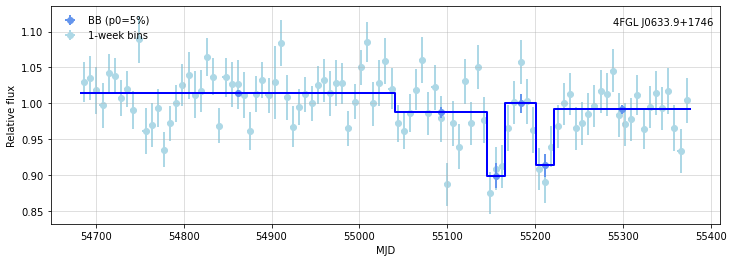

In [ ]:
from wtlike.config import *
config = Config()
if config.valid:
    wtl = WtLike('Geminga', week_range=(9,108) )
    wtl.bb_view().plot();

In [ ]:
#collapse_input
full = None
# code for the demo--this shouid be collapsed
def demo(clear=False):
    """
    ## Test/Demonstration with 3C 279
    
    > Note that this also demonstrates using `nbdoc` to have a single Jupyterlab cell generate a document
    
    First, the weekly light curve:
    {out1}    {fig1}
    
    Replot the figure with an expanded scale to see position of a flare:
    {fig2}
    {out3}    {fig3}
    {out4}    {fig4}
    
    Table of BB fits
    {bb_table}
    
    This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
    {kerr_fig4}
    """
    global full
    
    #with capture_print('Create full weekly light curve') as out1:
    full = WtLike('3C 279', clear=clear)
    
    fig1 = figure(
        full.plot(yscale='log', ylim=(0.2,20), figsize=(15,5), xlabel='MJD', fmt='.', fignum=1),
        caption='Full scale', width=600)  
    
    fig2 = figure(
        full.plot(  figsize=(15,5), xlabel='MJD', fmt='o', fignum=2,  xlim=(57100, 57300),),
        width=600)  
    
    with capture_print('Define orbit-based subset around large flare at MJD 57189') as out3:
        orbit = full.view((57186, 57191, 0))
    fig3 = figure(
        orbit.plot(fmt='o', tzero=57186,   fignum=3 ),
            width=600)
    
    with capture_print('Apply BB and overplot it with the cells on which it is based') as out4:
        bborbit = orbit.bb_view()
    fig4 = figure(
        bborbit.plot(fmt='o', tzero=57186,   fignum=4),
                width=600)
    
    bb_table = orbit.fluxes
    
    kerr_fig4 = image('kerr_fig4.png', width=600, caption=None)
    return locals()

if config.valid:
    nbdoc(demo, False)

('3C 279',)
SourceData:  3C 279: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       180,481 photons from 2008-08-04 to 2021-07-30
	 exposure: 2,870,182 intervals,  average effective area 2391 cm^2 for 85.7 Ms
	 rates:  source 4.68e-07/s, background 4.13e-07/s, S/N ratio 1.14e+00
CellData: Bin photon data into 677 1-week bins from 54683.0 to 59422.0
LightCurve: select 667 cells for fitting with e>5 & n>2


/home/burnett/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Test/Demonstration with 3C 279

> Note that this also demonstrates using `nbdoc` to have a single Jupyterlab cell generate a document

First, the weekly light curve:
{out1}    <figure style="margin-left: 5%" title="Figure 1">  <a href="images/demo_fig_01.png" title="images/demo_fig_01.png">    <img src="images/demo_fig_01.png" alt="Figure 1 at images/demo_fig_01.png" width=600>   </a>  <figcaption><b>Figure 1</b>. Full scale</figcaption></figure>

Replot the figure with an expanded scale to see position of a flare:
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/demo_fig_02.png" title="images/demo_fig_02.png">    <img src="images/demo_fig_02.png" alt="Figure 2 at images/demo_fig_02.png" width=600>   </a> </figure>
<details  class="nbdoc-description" >  <summary> Define orbit-based subset around large flare at MJD 57189 </summary>  <div style="margin-left: 5%"><pre>CellData: Bin photon data into 80 orbit-based bins from 57186.1 to 57191.0<br>LightCurve: select 33 cells for fitting with e&gt;5 & n&gt;2<br></pre></div> </details>    <figure style="margin-left: 5%" title="Figure 3">  <a href="images/demo_fig_03.png" title="images/demo_fig_03.png">    <img src="images/demo_fig_03.png" alt="Figure 3 at images/demo_fig_03.png" width=600>   </a> </figure>
<details  class="nbdoc-description" >  <summary> Apply BB and overplot it with the cells on which it is based </summary>  <div style="margin-left: 5%"><pre>Bayesian Blocks: partitioning 33 cells using LikelihoodFitness with penalty 5.0%<br>	found 10 / 33 blocks.<br>LightCurve: Loaded 10 / 10 cells for fitting<br></pre></div> </details>    <figure style="margin-left: 5%" title="Figure 4">  <a href="images/demo_fig_04.png" title="images/demo_fig_04.png">    <img src="images/demo_fig_04.png" alt="Figure 4 at images/demo_fig_04.png" width=600>   </a> </figure>

Table of BB fits
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>t</th>
      <th>tw</th>
      <th>n</th>
      <th>e</th>
      <th>ts</th>
      <th>flux</th>
      <th>errors</th>
      <th>limit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>57186.253</td>
      <td>0.025</td>
      <td>9</td>
      <td>5.513</td>
      <td>15.400</td>
      <td>2.452</td>
      <td>(-0.965, 1.241)</td>
      <td>5.003</td>
    </tr>
    <tr>
      <td>57186.385</td>
      <td>0.026</td>
      <td>9</td>
      <td>5.542</td>
      <td>16.300</td>
      <td>2.619</td>
      <td>(-0.992, 1.259)</td>
      <td>5.181</td>
    </tr>
    <tr>
      <td>57186.517</td>
      <td>0.026</td>
      <td>3</td>
      <td>5.484</td>
      <td>0.000</td>
      <td>0.051</td>
      <td>(-0.051, 0.739)</td>
      <td>2.025</td>
    </tr>
    <tr>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <td>57190.622</td>
      <td>0.032</td>
      <td>20</td>
      <td>10.226</td>
      <td>63.200</td>
      <td>3.374</td>
      <td>(-0.844, 0.98)</td>
      <td>5.219</td>
    </tr>
    <tr>
      <td>57190.694</td>
      <td>0.020</td>
      <td>11</td>
      <td>6.344</td>
      <td>31.300</td>
      <td>3.054</td>
      <td>(-0.975, 1.206)</td>
      <td>5.454</td>
    </tr>
    <tr>
      <td>57190.763</td>
      <td>0.016</td>
      <td>11</td>
      <td>5.161</td>
      <td>37.800</td>
      <td>3.982</td>
      <td>(-1.23, 1.504)</td>
      <td>6.945</td>
    </tr>
  </tbody>
</table>
</div>

This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
<figure style="margin-left: 5%" title="Figure 5">  <a href="images/demo_fig_05.png" title="images/demo_fig_05.png">    <img src="images/demo_fig_05.png" alt="Figure 5 at images/demo_fig_05.png" width=600>   </a> </figure>


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Wed Aug 11 14:11:34 PDT 2021


Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell
